In [1]:
# back to project root
%cd /mnt/c/research

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm
import sys
from glob import glob
import yaml

sys.path.append('src')
from group.passing.dataset import make_all_data
from utility.logger import logger
from utility.activity_loader import load_individuals

/mnt/c/research


/mnt/c/research/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLEDEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Indivisual Activity をロード

In [3]:
cfg_path = "config/passing/pass_train.yaml"
with open(cfg_path, "r") as f:
    train_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["individual"], "r") as f:
    ind_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["group"], "r") as f:
    grp_cfg = yaml.safe_load(f)
mdl_cfg_path = grp_cfg["passing"]["cfg_path"]
with open(mdl_cfg_path, "r") as f:
    mdl_cfg = yaml.safe_load(f)

In [4]:
data_dirs_all = {}
for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
    for surgery_num in surgery_items.keys():
        dirs = sorted(glob(os.path.join("data", room_num, surgery_num, "passing", "*")))
        data_dirs_all[f"{room_num}_{surgery_num}"] = dirs

logger.info(f"=> loading individuals from {data_dirs_all}")
inds = {}
for key_prefix, dirs in data_dirs_all.items():
    for model_path in dirs:
        num = model_path.split("/")[-1]
        json_path = os.path.join(model_path, ".json", "individual.json")
        tmp_inds, _ = load_individuals(json_path, ind_cfg)
        for pid, ind in tmp_inds.items():
            inds[f"{key_prefix}_{num}_{pid}"] = ind

2022-05-23 15:48:20 [INFO]: => loading individuals from {'02_001': ['data/02/001/passing/01', 'data/02/001/passing/02', 'data/02/001/passing/03', 'data/02/001/passing/04', 'data/02/001/passing/05', 'data/02/001/passing/06', 'data/02/001/passing/07', 'data/02/001/passing/08', 'data/02/001/passing/09', 'data/02/001/passing/10', 'data/02/001/passing/11', 'data/02/001/passing/12', 'data/02/001/passing/13', 'data/02/001/passing/14', 'data/02/001/passing/15', 'data/02/001/passing/16', 'data/02/001/passing/17', 'data/02/001/passing/18', 'data/02/001/passing/19', 'data/02/001/passing/20', 'data/02/001/passing/21', 'data/02/001/passing/22', 'data/02/001/passing/23'], '08_001': ['data/08/001/passing/01', 'data/08/001/passing/02', 'data/08/001/passing/03', 'data/08/001/passing/04', 'data/08/001/passing/05', 'data/08/001/passing/06', 'data/08/001/passing/07', 'data/08/001/passing/08', 'data/08/001/passing/09', 'data/08/001/passing/10', 'data/08/001/passing/11', 'data/08/001/passing/12', 'data/08/0

# 特徴量抽出とデータ生成

In [5]:
# create model
x_dict, y_dict = make_all_data(inds, train_cfg["dataset"]["setting"], grp_cfg["passing"]["default"], logger)

2022-05-23 15:48:28 [INFO]: => createing time series 02_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.30it/s]
2022-05-23 15:48:30 [INFO]: => createing time series 08_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 14.04it/s]
2022-05-23 15:48:33 [INFO]: => createing time series 09_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.56it/s]
2022-05-23 15:48:34 [INFO]: => extracting feature 02_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 

In [6]:
for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
    print(room_num)
    
    y_lst_all = []
    for key, y_lst in y_dict.items():
        if key[:2] == room_num:
            y_lst_all += y_lst

    len_pass = len([i for i in y_lst_all if i == 1])
    len_not_pass = len([i for i in y_lst_all if i == 0])

    print(f'all length:{len(y_lst_all)}')
    print(f'passing: {len_pass}')
    print(f'not passing: {len_not_pass}')
    
print('total')
y_lst_all = []
for key, y_lst in y_dict.items():
    y_lst_all += y_lst

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

02
all length:148713
passing: 582
not passing: 148131
08
all length:135069
passing: 1126
not passing: 133943
09
all length:87405
passing: 366
not passing: 87039
total
all length:371187
passing: 2074
not passing: 369113


In [7]:
# setting random seed
np.random.seed(train_cfg["dataset"]["random_seed"])
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

train_ratio = train_cfg["dataset"]["train_ratio"] + train_cfg["dataset"]["val_ratio"]
train_len = int(len(x_dict) * train_ratio)

train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}

In [8]:
train_1 = {key: y_dict[key] for key in train_keys if 1 in y_dict[key]}
print(len(train_1))
train_0 = {key: y_dict[key] for key in train_keys if 0 in y_dict[key]}
print(len(train_0))

train_1_frame = 0
train_0_frame = 0
for data in y_train_dict.values():
    train_1_frame += len([val for val in data if val == 1])
    train_0_frame += len([val for val in data if val == 0])
    
print(train_1_frame)
print(train_0_frame)

56
4052
1774
293698


In [9]:
test_1 = {key: y_dict[key] for key in test_keys if 1 in y_dict[key]}
print(len(test_1))
test_0 = {key: y_dict[key] for key in test_keys if 0 in y_dict[key]}
print(len(test_0))

test_1_frame = 0
test_0_frame = 0
for data in y_test_dict.values():
    test_1_frame += len([val for val in data if val == 1])
    test_0_frame += len([val for val in data if val == 0])
print(test_1_frame)
print(test_0_frame)

18
1013
300
75415


# 分布

In [10]:
def extract_feature(x_dict, y_dict, col_num, is_pass):
    hist = {}
    for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
        for _ in surgery_items.keys():
            hist_room = []
            for key, x_lst, y_lst in zip(x_dict.keys(), x_dict.values(), y_dict.values()):
                x_lst = np.array(x_lst)
                if room_num in key and is_pass in y_lst:
                    hist_room += x_lst.T[col_num].tolist()
            hist[room_num] = hist_room
        
    return hist

## 受け渡し動作中の距離の分布を見る

In [11]:
hist_dist_1 = extract_feature(
    x_dict,
    y_dict,
    0,
    1
)

0.7992332011107949
0.12260480893211143


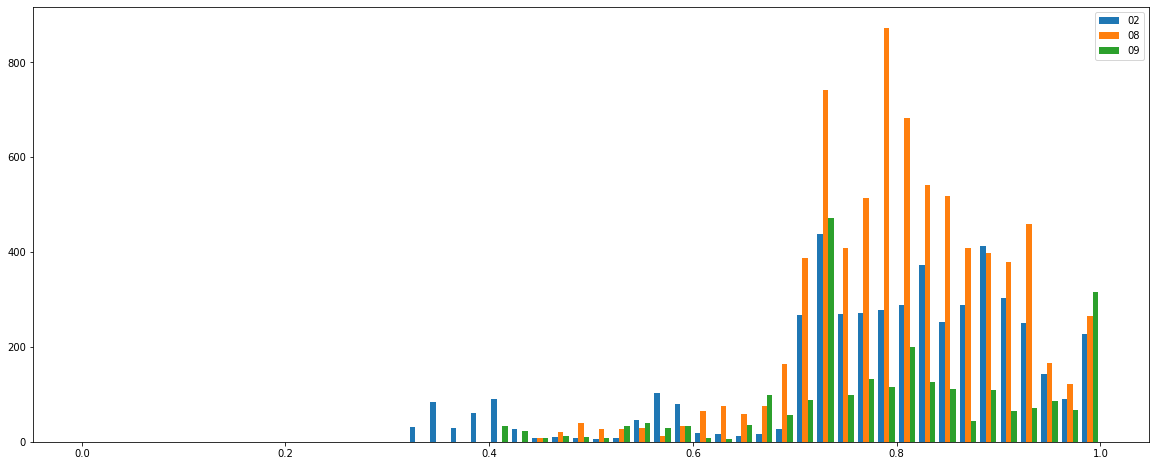

In [12]:
data = []
for vals in hist_dist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_dist_1.values(), bins=50, range=(0, 1), label=list(hist_dist_1.keys()))
# plt.vlines(np.mean(data), 0, 1000)
plt.legend()

In [13]:
hist_dist_0 = extract_feature(
    x_dict,
    y_dict,
    0,
    0
)

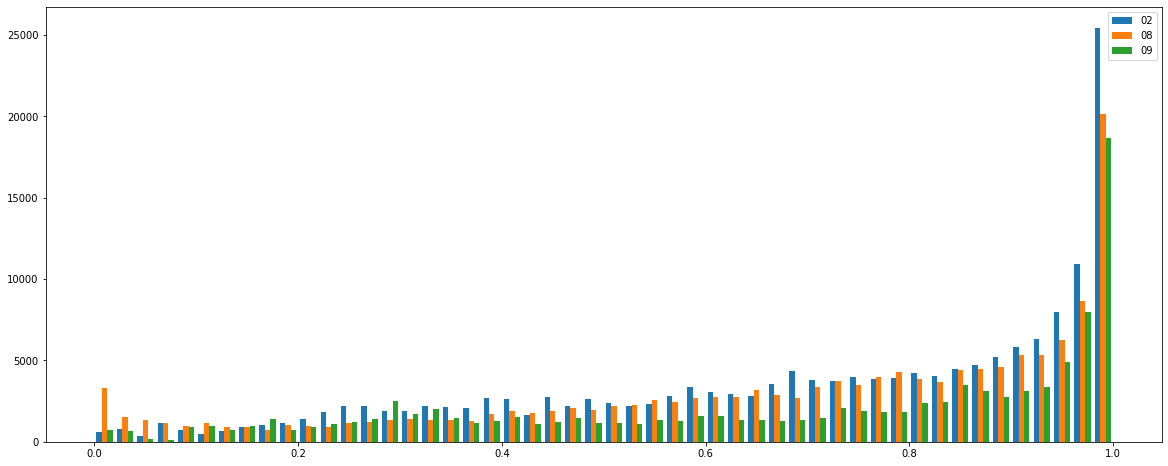

In [14]:
plt.figure(figsize=(20, 8))
plt.hist(hist_dist_0.values(), bins=50, range=(0, 1), label=list(hist_dist_0.keys()))
plt.legend()

## 受け渡し動作中の体の向きの分布を見る

In [15]:
hist_body_1 = extract_feature(
    x_dict,
    y_dict,
    1,
    1
)

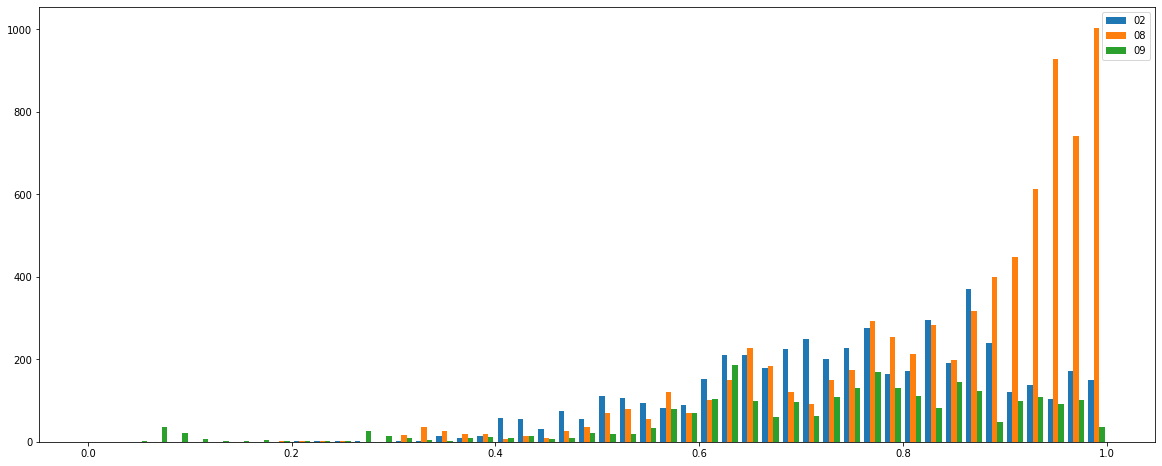

In [16]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_1.values(), bins=50, range=(0, 1), label=list(hist_body_1.keys()))
plt.legend()

In [17]:
hist_body_0 = extract_feature(
    x_dict,
    y_dict,
    1,
    0
)

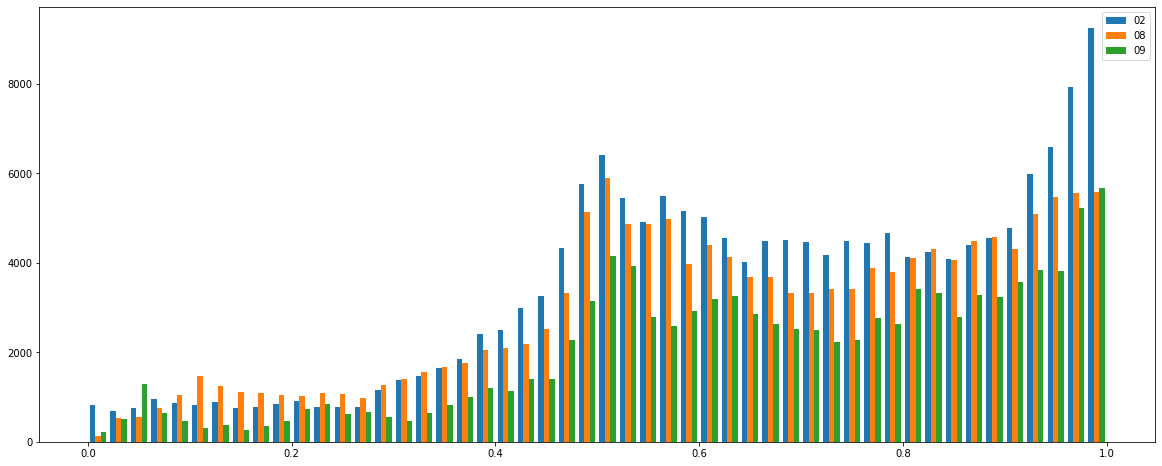

In [18]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_0.values(), bins=50, range=(0, 1), label=list(hist_body_0.keys()))
plt.legend()

## 受け渡し動作中の腕の上げ下げの分布を見る

In [19]:
hist_arm_1 = extract_feature(
    x_dict,
    y_dict,
    2,
    1
)

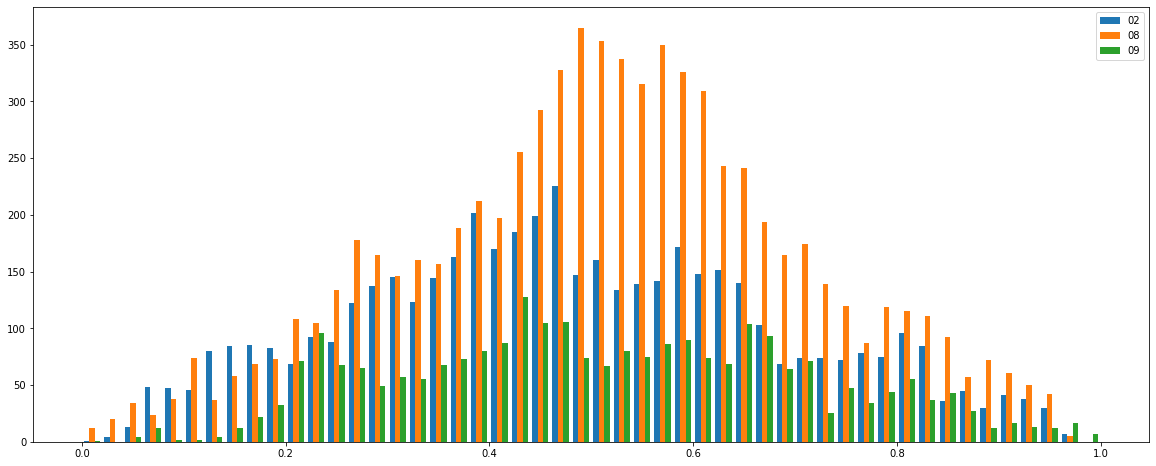

In [20]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_1.values(), bins=50, range=(0, 1), label=list(hist_arm_1.keys()))
plt.legend()

In [21]:
hist_arm_0 = extract_feature(
    x_dict,
    y_dict,
    2,
    0
)

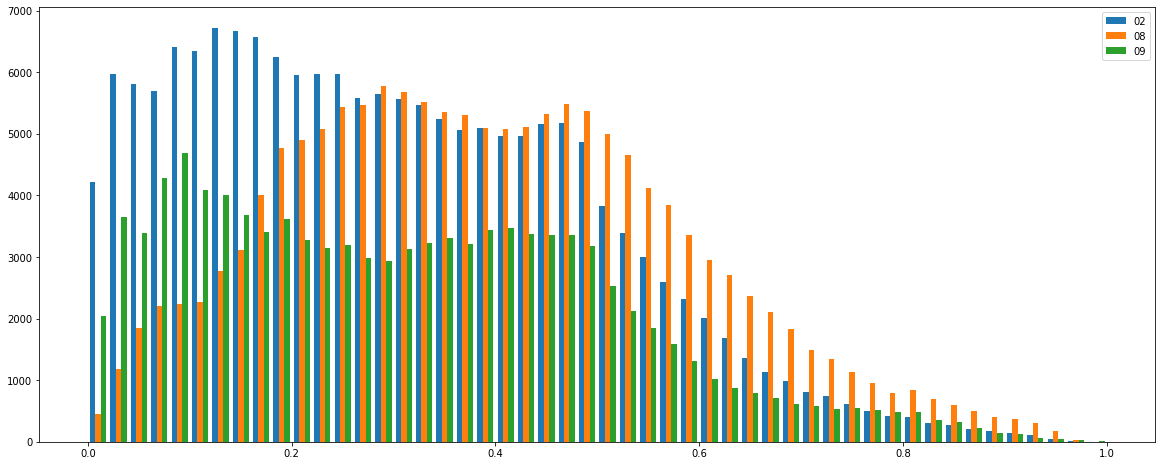

In [22]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_0.values(), bins=50, range=(0, 1), label=list(hist_arm_0.keys()))
plt.legend()

## 受け渡し動作中の手首の距離の分布を見る

In [23]:
hist_wrist_1 = extract_feature(
    x_dict,
    y_dict,
    3,
    1
)

0.46117444000190083
0.3533815816215425


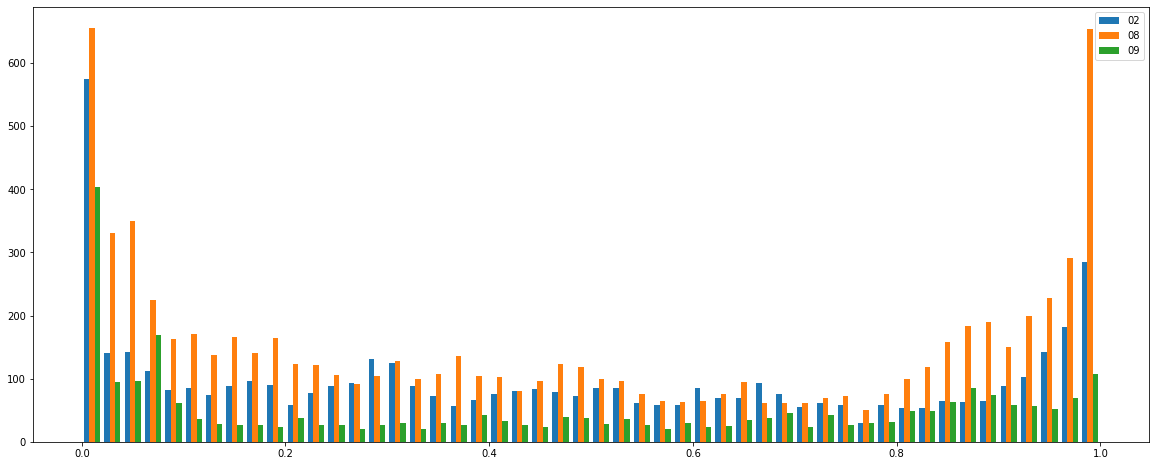

In [24]:
data = []
for vals in hist_wrist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_1.values(), bins=50, range=(0, 1), label=list(hist_wrist_1.keys()))
plt.legend()

In [25]:
hist_wrist_0 = extract_feature(
    x_dict,
    y_dict,
    3,
    0
)

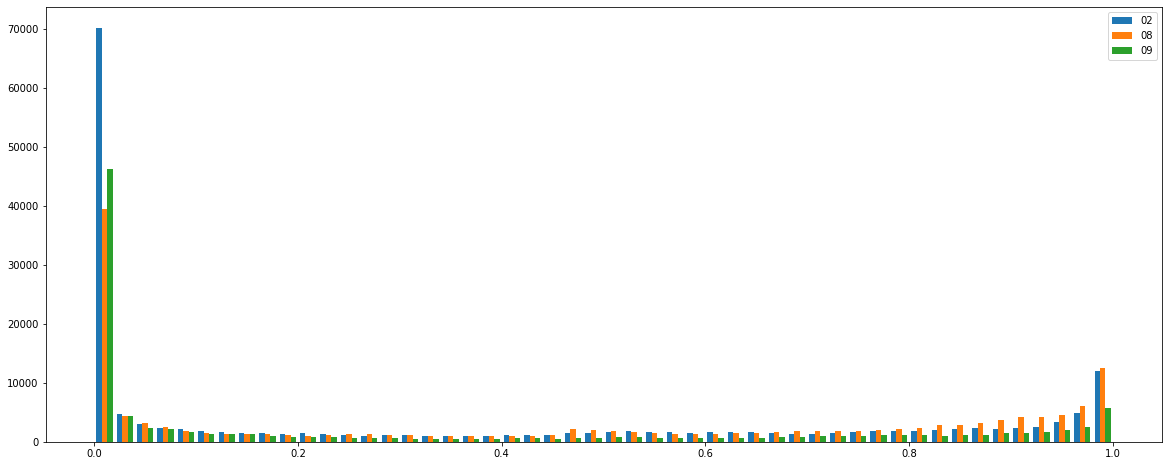

In [26]:
plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_0.values(), bins=50, range=(0, 1), label=list(hist_wrist_0.keys()))
plt.legend()

# 時系列でプロット

02_001_02_10_11


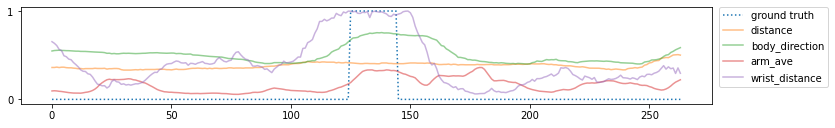

02_001_02_10_13


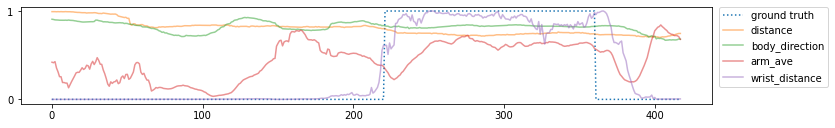

02_001_03_27_31


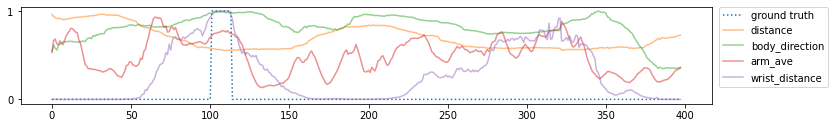

02_001_04_43_42


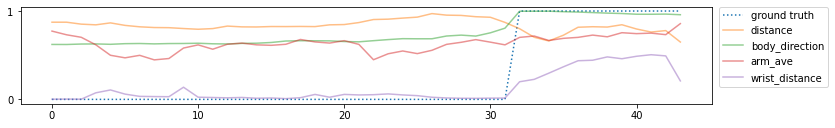

02_001_05_47_51


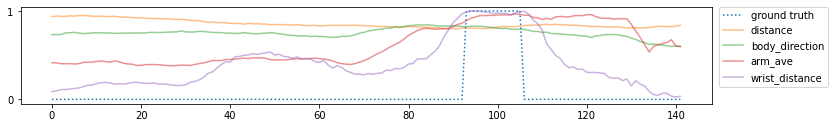

02_001_06_58_61


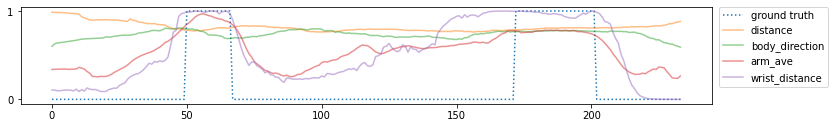

02_001_08_81_85


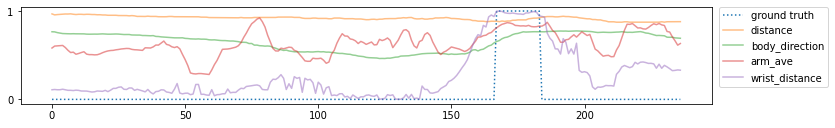

02_001_09_97_104


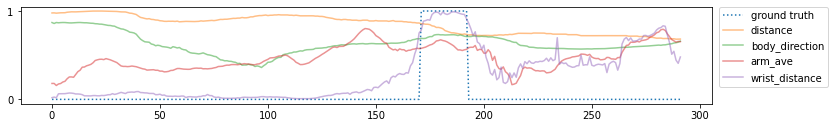

02_001_10_125_119


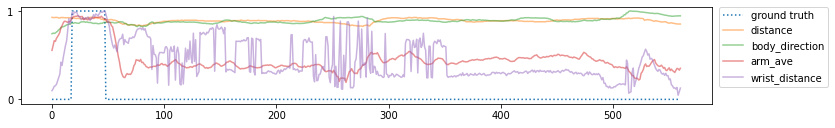

02_001_11_134_140


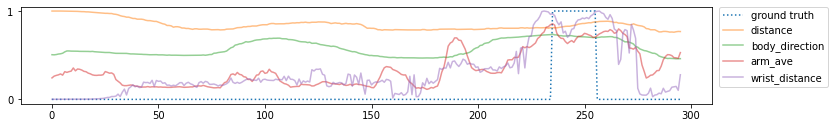

02_001_13_166_167


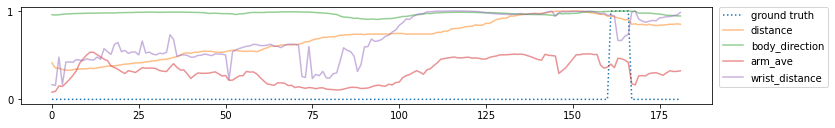

02_001_15_191_202


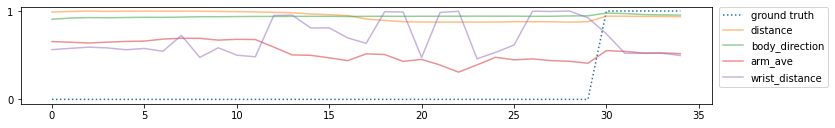

02_001_15_202_191


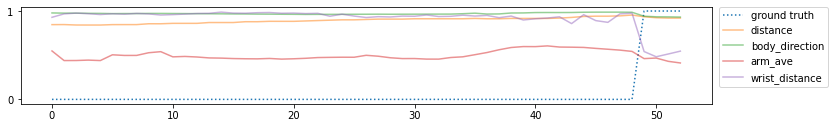

02_001_18_247_251


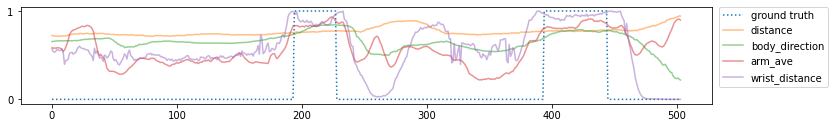

02_001_19_259_262


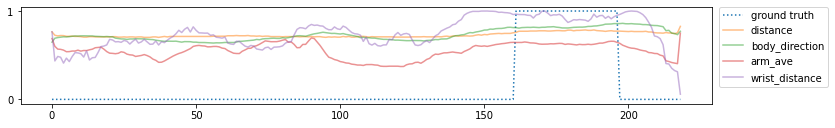

02_001_20_268_270


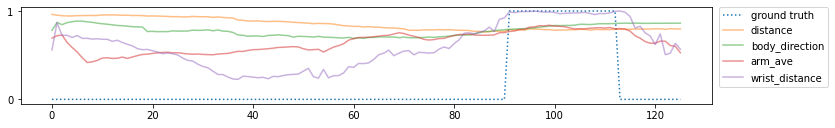

02_001_20_268_266


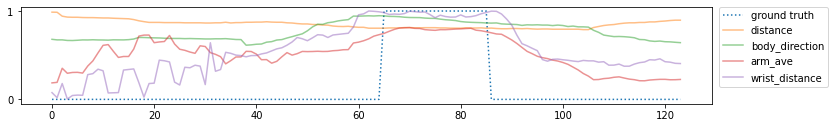

02_001_21_288_287


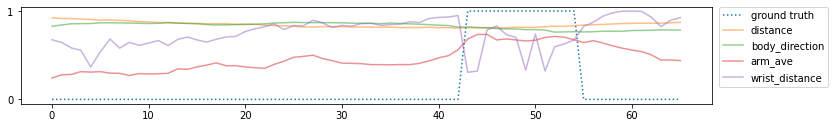

02_001_22_289_295


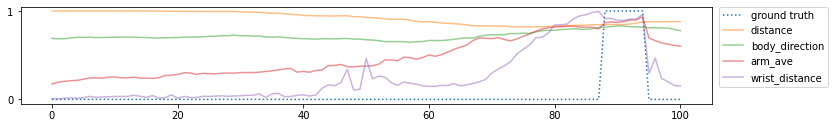

02_001_23_304_309


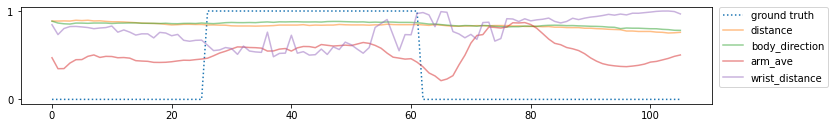

08_001_01_3_6


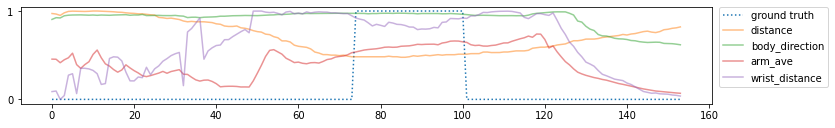

08_001_03_26_32


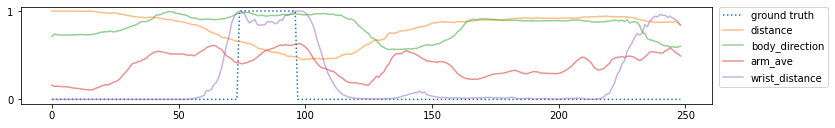

08_001_04_41_39


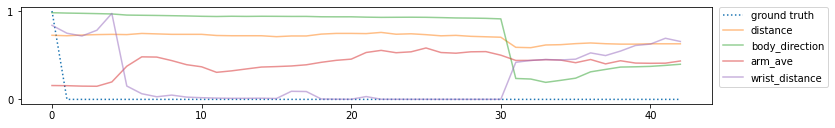

08_001_05_50_52


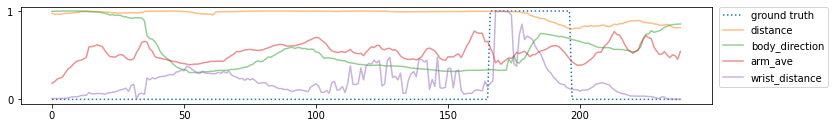

08_001_06_57_62


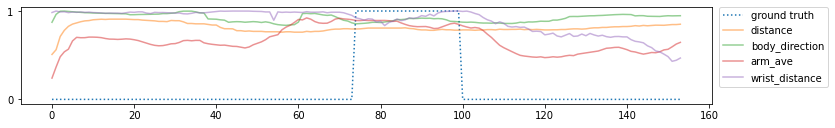

08_001_07_68_70


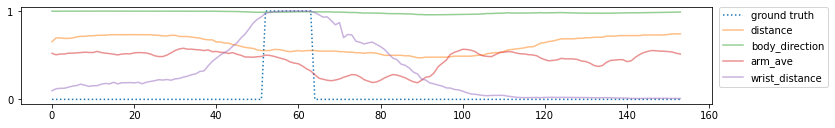

08_001_08_74_75


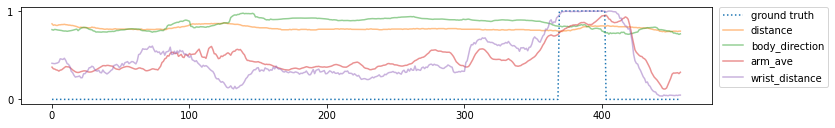

08_001_09_91_89


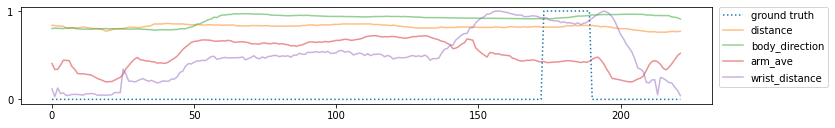

08_001_10_99_101


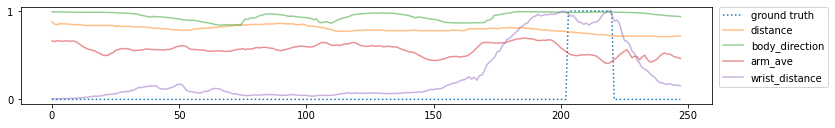

08_001_11_115_116


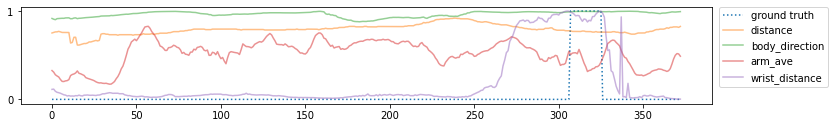

08_001_12_136_138


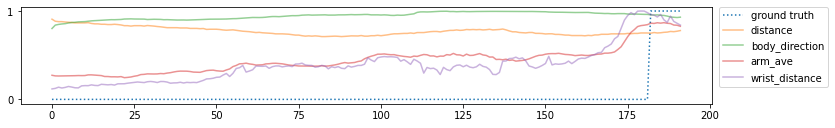

08_001_13_146_147


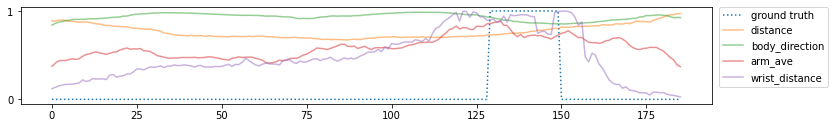

08_001_15_168_169


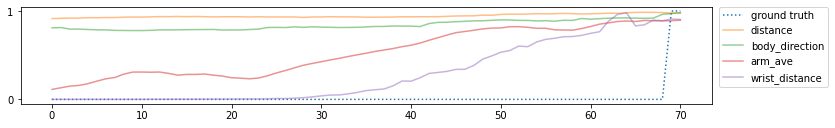

08_001_15_169_168


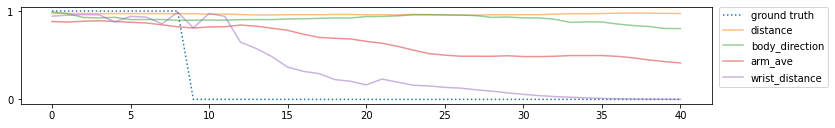

08_001_16_178_181


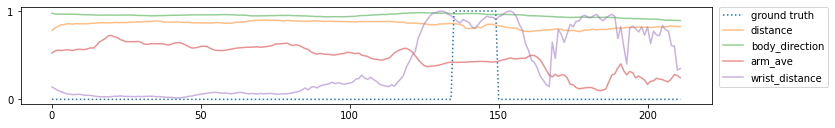

08_001_17_188_189


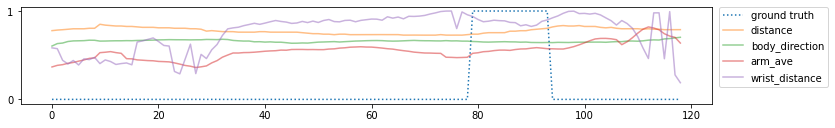

08_001_18_195_197


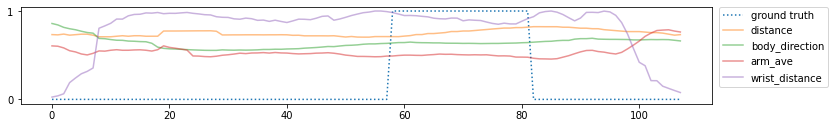

08_001_19_203_206


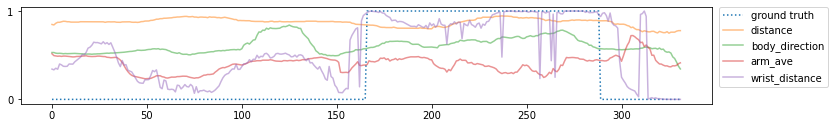

08_001_20_215_220


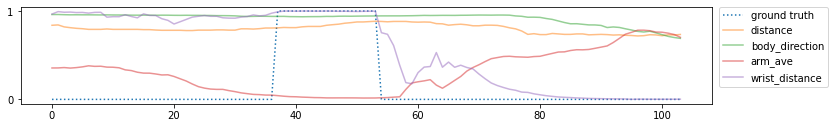

08_001_21_226_228


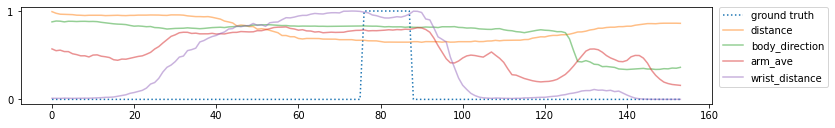

08_001_23_242_247


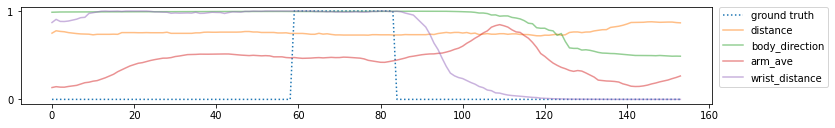

08_001_24_252_250


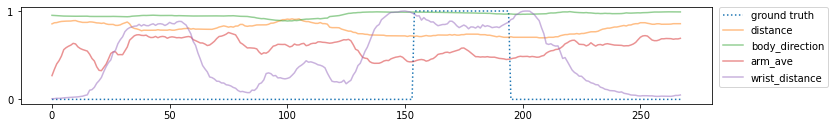

08_001_25_266_271


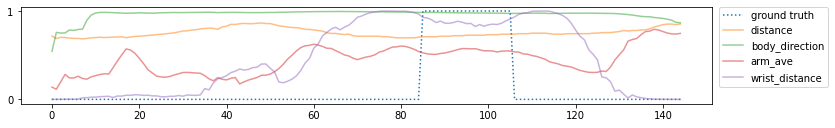

08_001_26_278_283


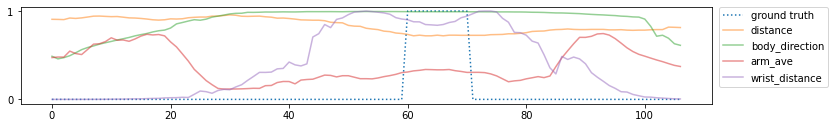

08_001_27_297_290


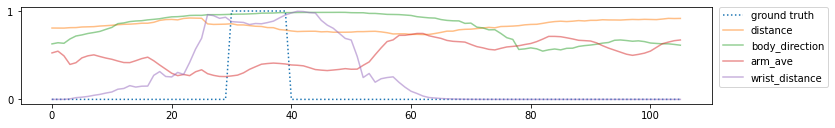

08_001_29_315_316


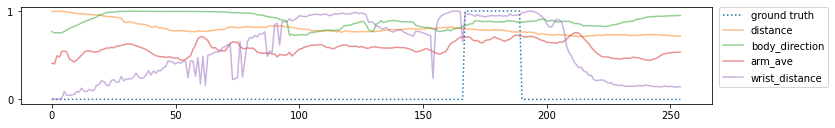

08_001_30_321_322


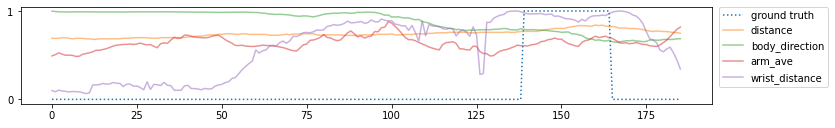

08_001_31_332_339


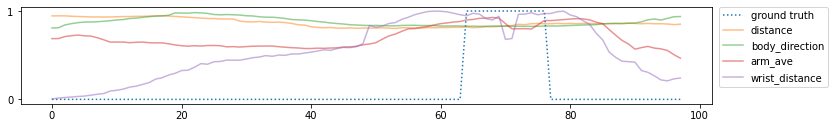

08_001_32_343_342


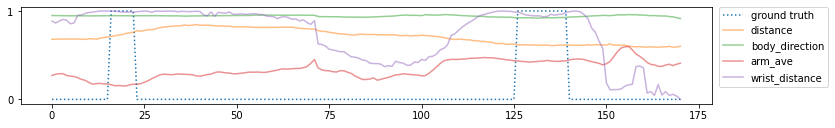

08_001_33_352_353


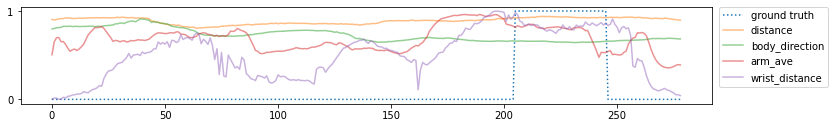

08_001_34_361_362


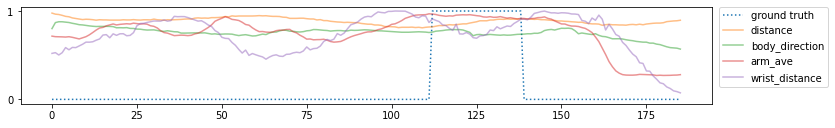

08_001_35_370_368


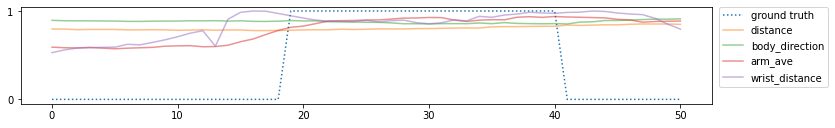

08_001_36_380_381


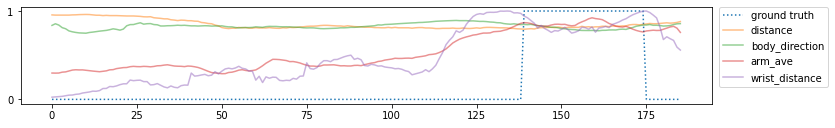

08_001_37_388_389


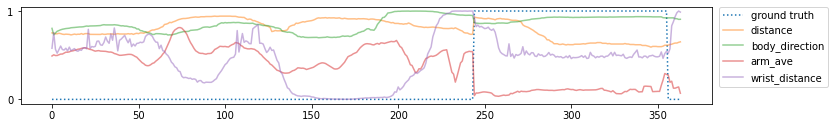

08_001_37_389_388


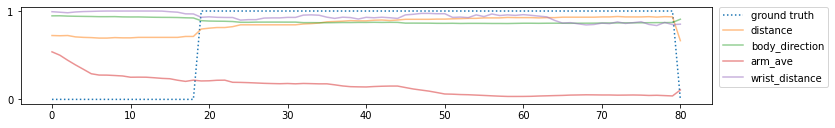

08_001_38_395_396


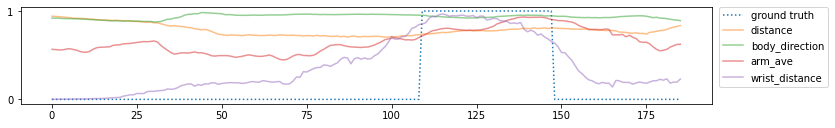

08_001_39_404_410


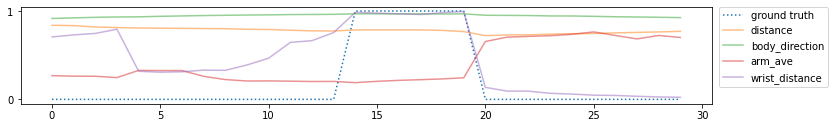

08_001_39_410_404


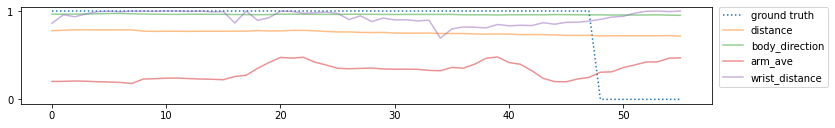

08_001_40_417_412


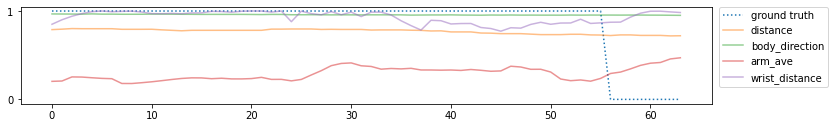

08_001_41_421_422


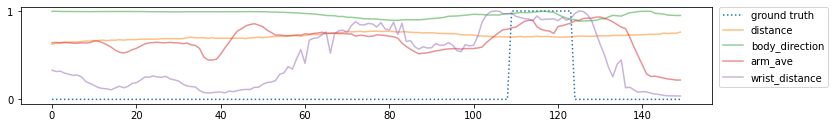

09_001_01_1_8


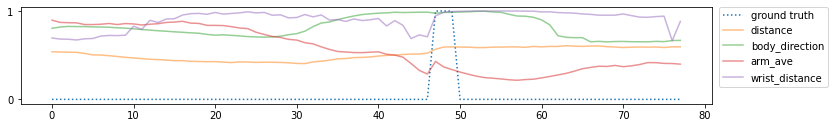

09_001_01_8_1


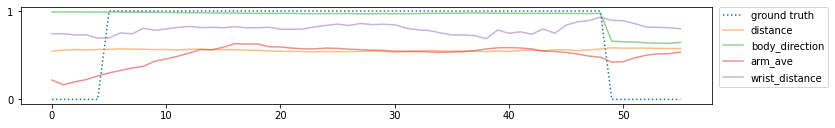

09_001_02_18_29


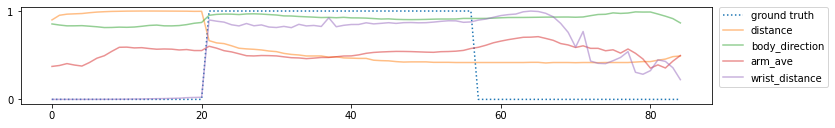

09_001_02_29_18


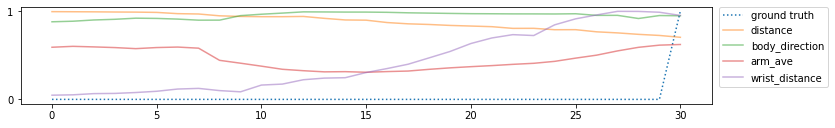

09_001_03_40_45


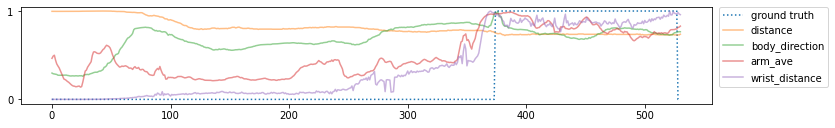

09_001_04_60_59


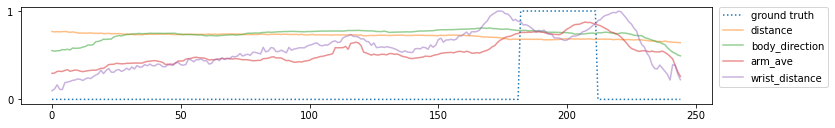

09_001_05_78_75


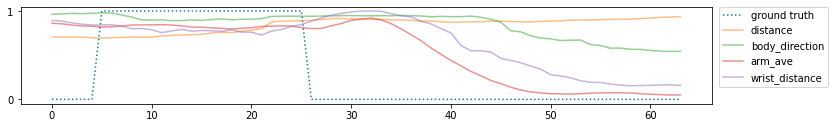

09_001_06_82_85


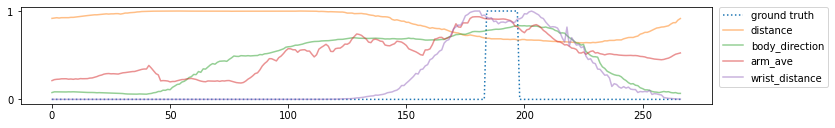

09_001_07_92_96


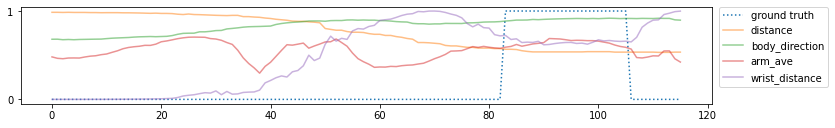

09_001_08_102_105


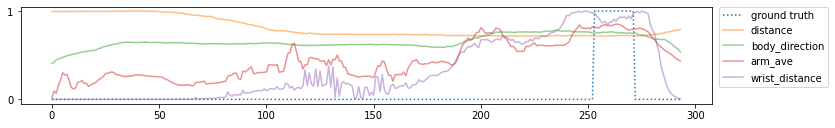

09_001_09_114_116


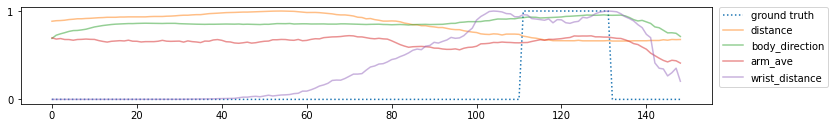

In [27]:
columns = ["distance", "body_direction", "arm_ave", "wrist_distance"]
for key in x_dict.keys():
    x_lst = np.array(x_dict[key])
    y_lst = y_dict[key]

    if 1 not in y_lst:
        continue

    if len(x_lst) < 30:
        continue

    print(key)
    plt.figure(figsize=(10, 1.5))
    # plt.rcParams["font.size"] = 20
    # plt.rcParams["font.family"] = 'Times New Roman'
    plt.plot(y_lst, linestyle=':', label='ground truth')
    for i, x in enumerate(x_lst.T):
        plt.plot(x, alpha=0.5, label=columns[i])
    plt.ylim((-0.05, 1.05))
    plt.yticks([0, 1])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

    plt.show()